In [1]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

#image and output formatting
import PIL
from PIL import Image
from tabulate import tabulate

#dir manip libraries
import os, sys, glob, pathlib, tempfile
from pathlib import Path

#import label encoding
from sklearn.preprocessing import LabelEncoder

#keras for model output customization
import keras
from keras import layers, ops

#tensorflow tools for model building
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling
from tensorflow.keras.optimizers import Adam, SGD

# Custom functions (this works, finally)
from pyTools.utils import *
from pyTools.preprocess import *
from pyTools.predict import *

# Print out versions for important tools
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Pillow version:", PIL.__version__)

Pandas version: 2.1.4
TensorFlow version: 2.16.1
Pillow version: 10.2.0


In [2]:
# Define the path to your Google Drive folder containing the images
data_dir = Path("../ML_Asm2_ProjFiles/classify_by_type")

# Ensure the directory exists
if not data_dir.exists():
    raise ValueError(f"Directory {data_dir} does not exist. Please check the path.")

In [3]:
image_count = len(list(data_dir.glob('*/**/*.png')))
print(image_count)

13766


In [4]:
print_directory_tree(data_dir)

├───classify_by_type/
    ├───bicycle/
    ├───continue/
    ├───crossing/
    ├───giveway/
    ├───laneend/
    ├───limitedtraffic/
    ├───noentry/
    ├───noparking/
    ├───parking/
    ├───rightofway/
    ├───roundabout/
    ├───speed/
    ├───stop/
    ├───trafficdirective/
    ├───traveldirection/
    ├───warning/


In [5]:
print_summary(data_dir)

+------------------+------------------+
|    Directory     | Number of Images |
+------------------+------------------+
|     bicycle      |       955        |
|     continue     |       866        |
|     crossing     |       766        |
|     giveway      |       897        |
|     laneend      |       792        |
|  limitedtraffic  |       798        |
|     noentry      |       1056       |
|    noparking     |       912        |
|     parking      |       946        |
|    rightofway    |       946        |
|    roundabout    |       767        |
|      speed       |       996        |
|       stop       |       710        |
| trafficdirective |       867        |
| traveldirection  |       797        |
|     warning      |       695        |
+------------------+------------------+


In [6]:
#print_duplicates(data_dir)

In [7]:
# Create the dataset and get the total image count
data = data_from_dir(data_dir)
print("Classes:", data.class_names)

Found 13766 files belonging to 16 classes.
Classes: ['bicycle', 'continue', 'crossing', 'giveway', 'laneend', 'limitedtraffic', 'noentry', 'noparking', 'parking', 'rightofway', 'roundabout', 'speed', 'stop', 'trafficdirective', 'traveldirection', 'warning']


In [8]:
data.element_spec

(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
data.cardinality().numpy()

138

[[[ 40]
  [ 75]
  [ 71]
  [ 43]
  [ 24]
  [ 29]
  [ 33]
  [ 33]
  [ 35]
  [ 24]
  [ 13]
  [ 10]
  [  9]
  [  6]
  [  8]
  [ 12]
  [ 11]
  [  8]
  [  7]
  [ 11]
  [  8]
  [  8]
  [  2]
  [  1]
  [  4]
  [  7]
  [  6]
  [  3]]

 [[ 19]
  [ 75]
  [ 75]
  [ 53]
  [ 31]
  [ 24]
  [ 34]
  [ 31]
  [ 35]
  [ 28]
  [ 17]
  [ 10]
  [ 11]
  [  6]
  [  7]
  [ 10]
  [ 11]
  [  7]
  [  4]
  [  7]
  [  4]
  [  4]
  [  6]
  [  7]
  [  5]
  [  2]
  [  0]
  [ 36]]

 [[  6]
  [ 57]
  [ 75]
  [ 63]
  [ 37]
  [ 20]
  [ 32]
  [ 32]
  [ 34]
  [ 32]
  [ 21]
  [ 10]
  [ 11]
  [  8]
  [  7]
  [ 10]
  [ 14]
  [  2]
  [  1]
  [  5]
  [  5]
  [  5]
  [ 24]
  [  7]
  [ 13]
  [ 56]
  [ 98]
  [132]]

 [[ 11]
  [ 36]
  [ 75]
  [ 72]
  [ 44]
  [ 25]
  [ 28]
  [ 33]
  [ 32]
  [ 36]
  [ 25]
  [ 14]
  [ 10]
  [  9]
  [ 10]
  [ 11]
  [ 12]
  [  5]
  [  4]
  [  5]
  [  9]
  [  4]
  [ 55]
  [ 95]
  [118]
  [113]
  [ 71]
  [ 29]]

 [[ 17]
  [ 15]
  [ 74]
  [ 75]
  [ 54]
  [ 32]
  [ 24]
  [ 34]
  [ 32]
  [ 35]
  [ 23]
  [ 13]


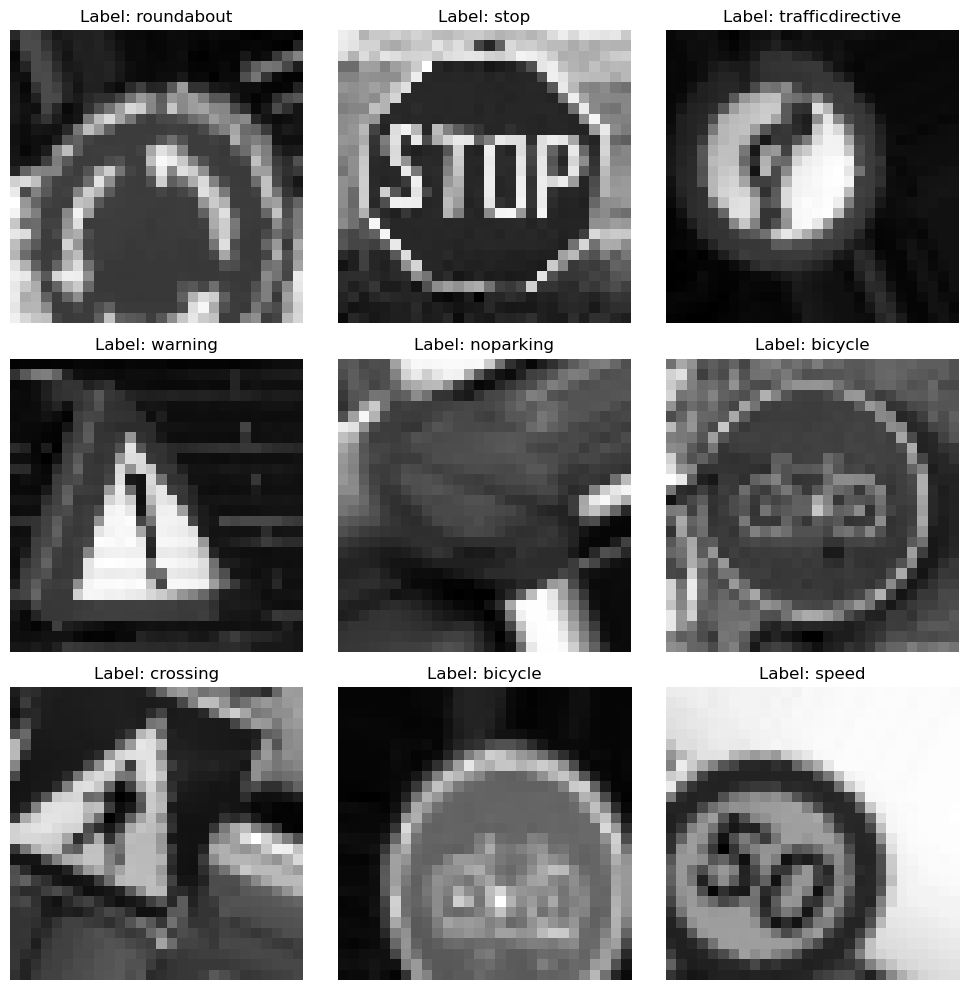

In [10]:
# Convert the class names to a NumPy array for easy indexing
class_names = np.array(data.class_names)

# Load the first batch from the training dataset
plt.figure(figsize=(10, 10))  # Define the figure size for a grid of images
for images, labels in data.take(1):
    # Plot 9 images in a 3x3 grid
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot in a 3x3 grid
        img = images[i].numpy().astype("uint8")  # Convert tensor to NumPy array
        print(img)
        # Use the numerical label to get the class name
        class_label = labels[i].numpy()  # Get the numerical label
        class_name = class_names[class_label]  # Get the corresponding class name

        plt.imshow(img, cmap='gray')  # This forces grayscale plotting

        plt.title(f"Label: {class_name}")  # Set the title with the class name
        plt.axis("off")  # Hide the axis for clarity

    plt.tight_layout()  # Adjust the layout for better spacing
    plt.show()  # Display all 9 images in a single plot


In [11]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

***compile()***:
  - ***optimizer***: Stochastic Gradient Descent, **Adoptive Moment Estimator(Adam)**
  - ***loss***: **Categorical (Focal) Cross Entropy**
  - ***metrics***: **(Categorical) Accuracy**, Top K Categorical, Categorical Cross Entropy, F1/Precision/Recall, AUC, IoU, MeanIoU

Initial design for baseline model.
Our goal was to design a simple Multilayer Perceptron baseline that utilizes keras libraries and utilities. Partially because of keras's versatility as a highly customisable tool, this model poses as a milestone for us to implement different modifications and tunings in development in the next steps.

In [14]:
# Define or compile the model
import tensorflow as tf

MLP = Sequential([
    keras.Input(shape=(28, 28, 1)),
    Rescaling(1/255),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(16, activation='softmax'), #This is fixed for multiclass classification
])

MLP.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['sparse_categorical_accuracy']
)

# Define any callbacks if needed
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Train the model with the given class weights dictionary
hist = MLP.fit(
    train,  # Your training data
    epochs=10,
    validation_data=val,  # Your validation data
    callbacks=[tensorboard_callback],  # Any additional callbacks you might need
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 2.2248 - sparse_categorical_accuracy: 0.3368 - val_loss: 2.0724 - val_sparse_categorical_accuracy: 0.3393
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 1.4001 - sparse_categorical_accuracy: 0.5901 - val_loss: 1.2827 - val_sparse_categorical_accuracy: 0.6626
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.1581 - sparse_categorical_accuracy: 0.6636 - val_loss: 1.0314 - val_sparse_categorical_accuracy: 0.7133
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 1.0296 - sparse_categorical_accuracy: 0.6999 - val_loss: 0.9808 - val_sparse_categorical_accuracy: 0.7204
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.9311 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.8941 - val_sparse_categorical_accuracy: 0.7522
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.8574 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.7995 - val_sparse_categorical_accuracy: 0.7737
Epoch 7/

In [15]:
# Evaluate the model
loss, accuracy = MLP.evaluate(test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.6826 - sparse_categorical_accuracy: 0.8224
Test loss: 0.6548794507980347
Test accuracy: 0.8146153688430786


In [16]:
MLP.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,616,178 (6.17 MB)

 Trainable params: 538,384 (2.05 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 1,076,770 (4.11 MB)

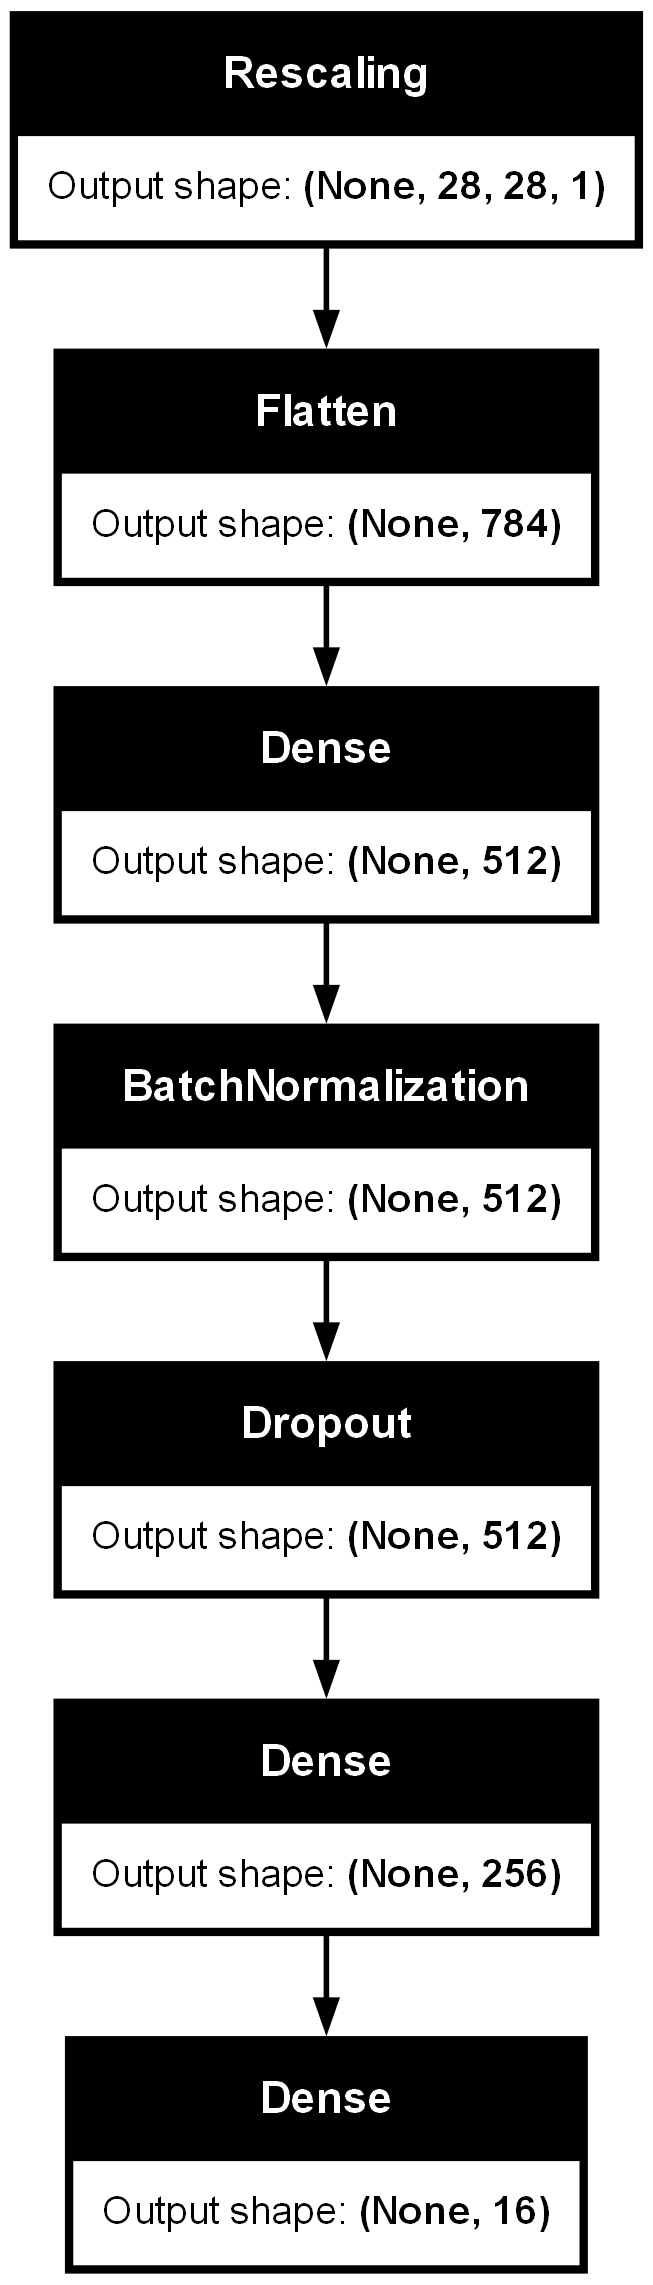

In [17]:
keras.utils.plot_model(MLP, show_shapes=True)

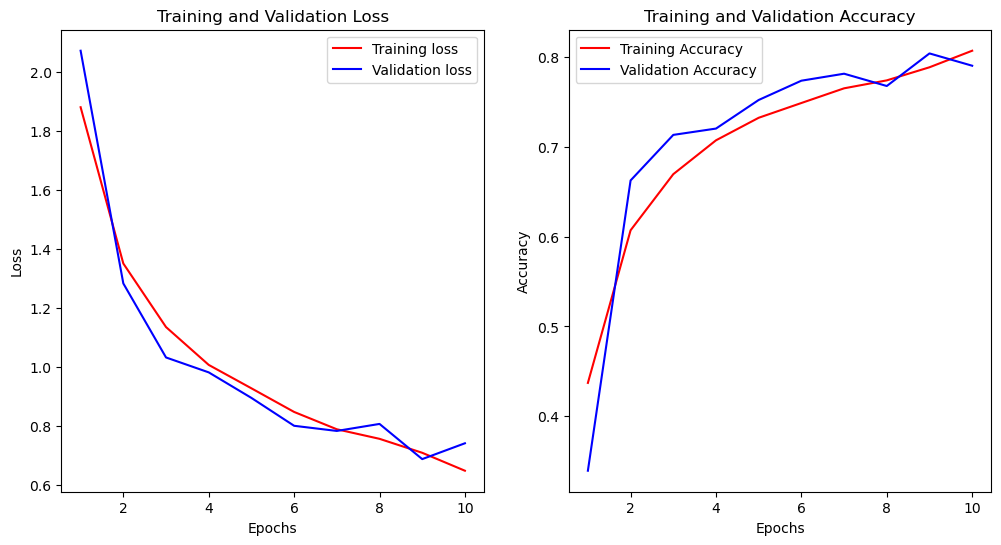

In [20]:
plot_learning_curve(hist)

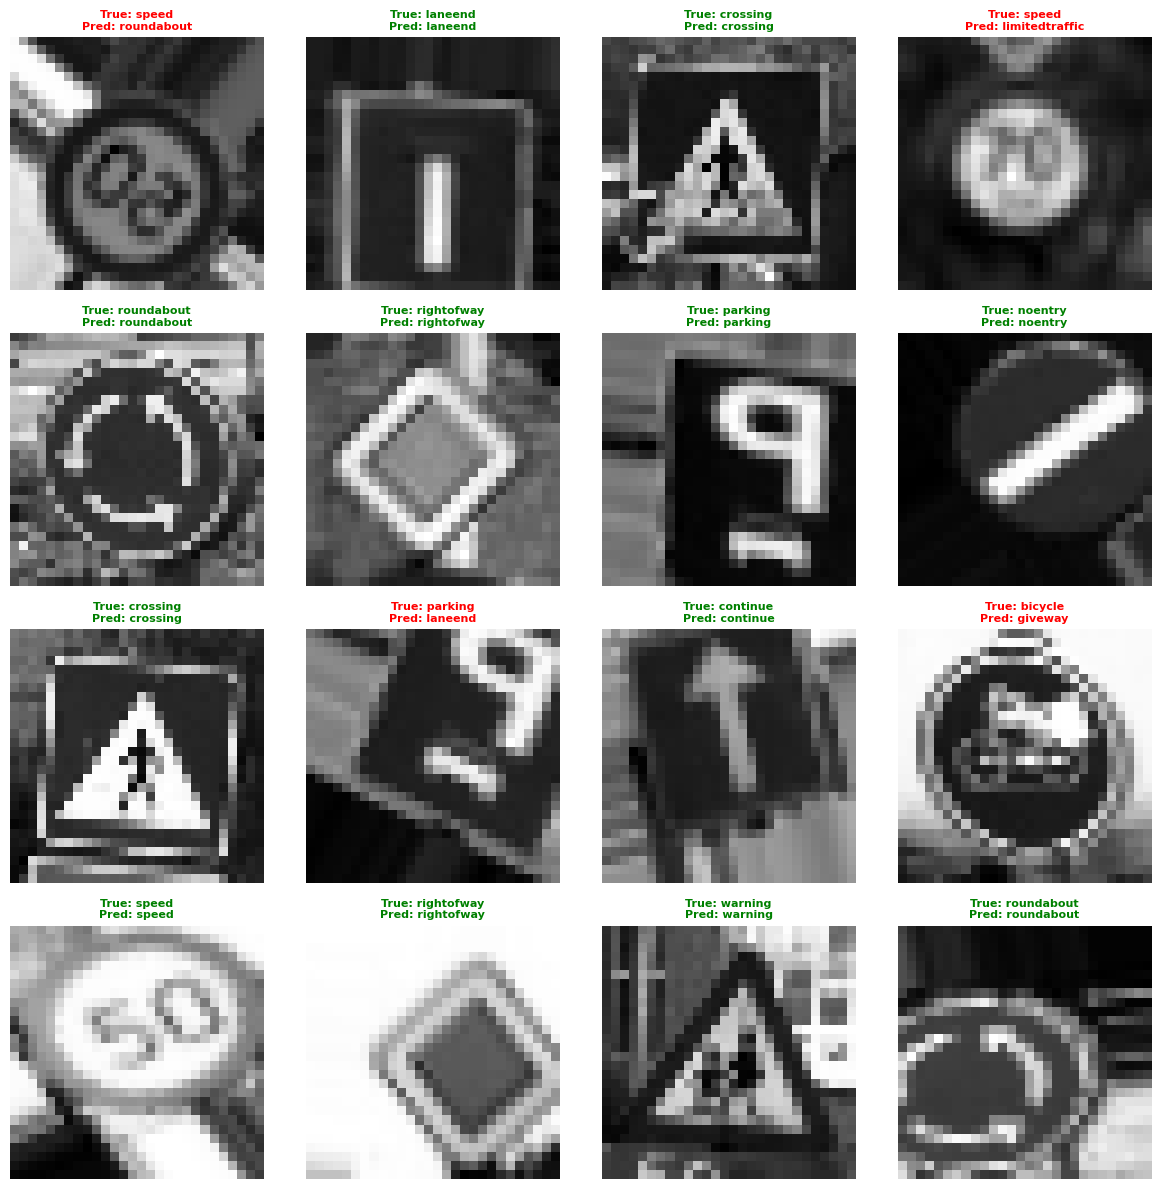

In [21]:
vResults_tf(MLP, val, data.class_names)

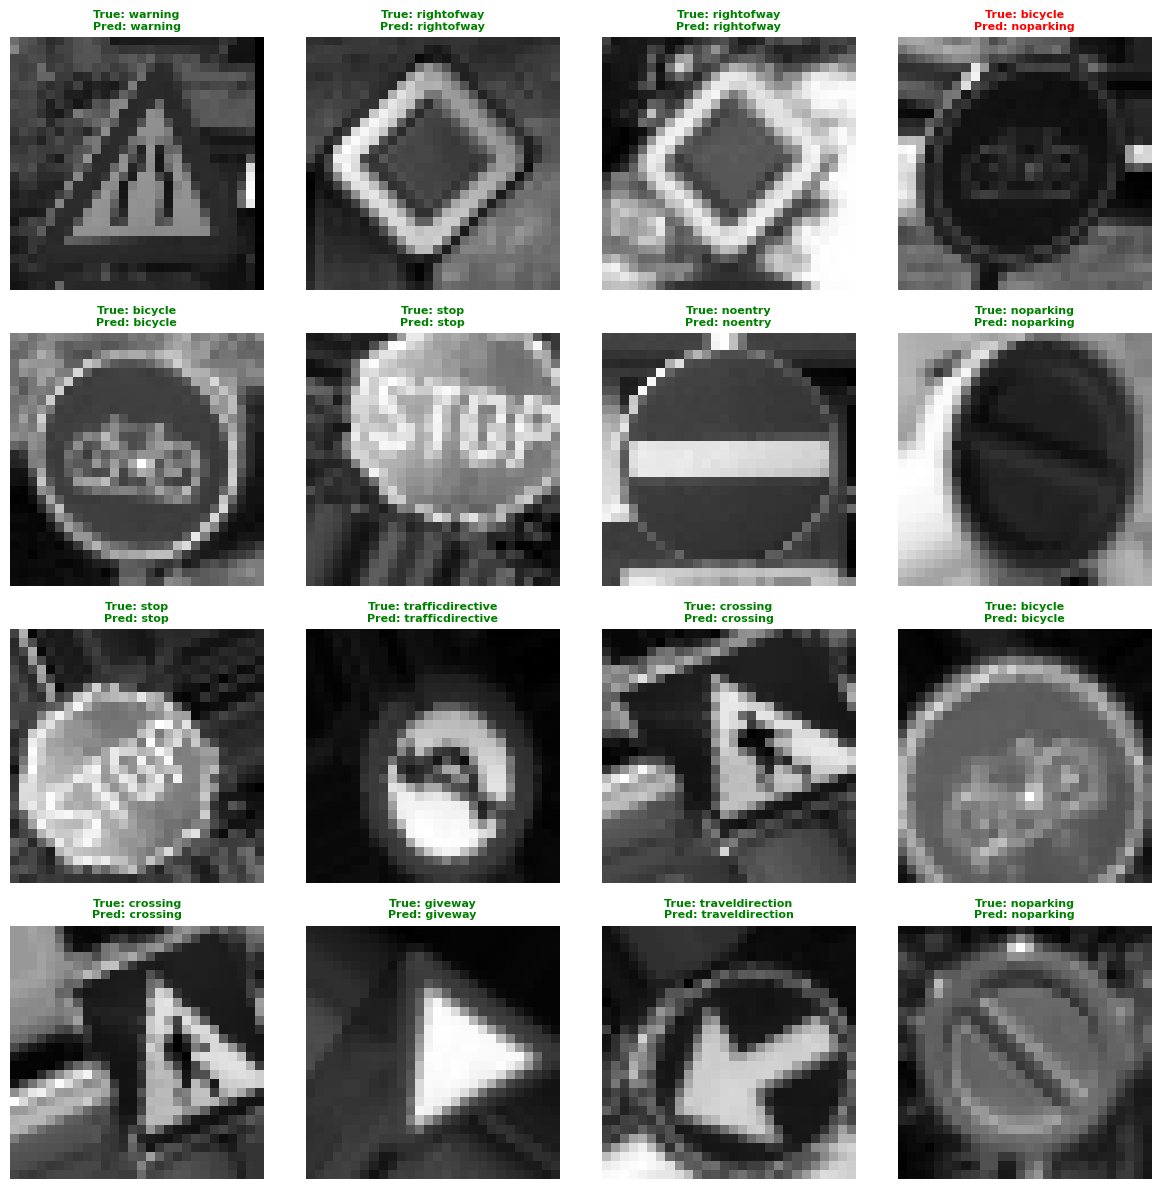

In [22]:
vResults_tf(MLP, test, data.class_names)

In [23]:
trueData = Path("../ML_Asm2_ProjFiles/tsrd-train")

In [24]:
image_count = len(list(trueData.glob('*.png')))
print(image_count)

4170


In [25]:
external_dir = "../ML_Asm2_ProjFiles/tsrd-train"  # Path to your dataset
raw_data = []

# Loop through all image files in the specified directory
for img_file in os.listdir(external_dir):
    if img_file.endswith((".png", ".jpg", ".jpeg", ".bmp")):
        # Get the full path to the image
        img_path = os.path.join(external_dir, img_file)
        
        # Preprocess the image using the defined function
        preprocessed_img = preprocess28(img_path)
        
        # Add the preprocessed image to the raw_data list
        raw_data.append(preprocessed_img)

# Shuffle the images to randomize the order
random.shuffle(raw_data)

# Convert the list to a NumPy array
raw_data = np.array(raw_data)

In [26]:
raw_data[0]

array([[[213],
        [216],
        [218],
        [220],
        [221],
        [216],
        [191],
        [191],
        [201],
        [182],
        [209],
        [213],
        [207],
        [216],
        [210],
        [202],
        [161],
        [141],
        [187],
        [189],
        [197],
        [170],
        [141],
        [108],
        [103],
        [ 78],
        [ 78],
        [ 91]],

       [[217],
        [221],
        [222],
        [219],
        [219],
        [221],
        [221],
        [221],
        [215],
        [181],
        [187],
        [166],
        [148],
        [203],
        [216],
        [209],
        [190],
        [134],
        [151],
        [162],
        [185],
        [178],
        [151],
        [110],
        [ 87],
        [ 91],
        [ 99],
        [101]],

       [[219],
        [221],
        [222],
        [218],
        [219],
        [219],
        [219],
        [218],
        [219],
        [200],
      

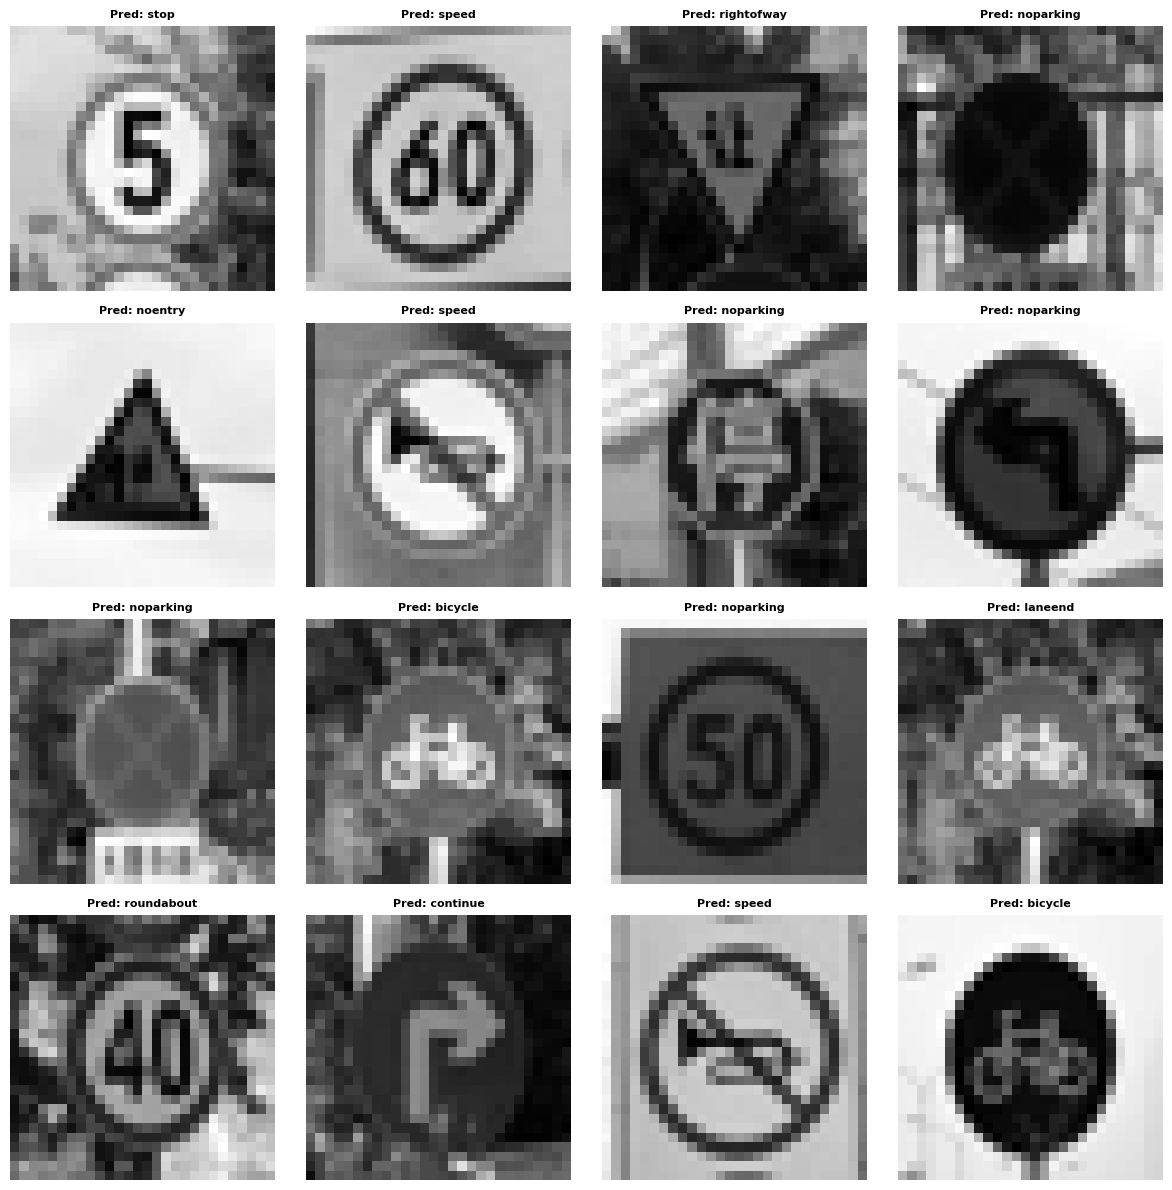

In [27]:
vResults_raw(MLP, raw_data, data.class_names)

# Notes: 
    Baseline model: 
     - Strength: 
     1. Classify data in the same dataset with very high accuracy. 
     2. Not computationally expensive
     
     - Weakness: 
     1. Inconsistent output metrics in each epoch. 
     2. Poor classification for external data
        -> Cause: Overfitting, Rudimentary Model. 

    Conclusion: Although the model did not perform well on external data, it reached a certain degree of generalization, which is fairly enough for this stage. 